# Machine Failure Prediction

## Libraries Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import plot_tree
from imblearn.combine import SMOTEENN
import numpy as np
import time

## Dataset Import

In [2]:
df = pd.read_csv('predictive_maintenance.csv')

## EDA

Effettuiamo ora l'analisi del dataset:

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.shape

(10000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
df['Target'] = df['Target'] ^ 1
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,1,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,1,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,1,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,1,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,1,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,1,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,1,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,1,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,1,No Failure


Le feature presenti sono le seguenti:
- **UDI** : Unique Device Identifier, ovvero un identificatore dell'istanza, univoco per ogni riga del dataset.
- **Product ID** : Identificatore del prodotto, univoco per ogni prodotto.
- **Type** : Feature categorica che indica la qualità del prodotto; assume valori discreti nel range [L, M, H], dove L='low Quality', M='Medium Quality', H='High Quality'.
- **Air Temperature** : Temperatura dell'aria in Kelvin (K), che potrebbe essere un parametro rilevante per il processo di produzione, indicando potenzialmente le condizioni ambientali o le impostazioni delle macchine.
- **Process Temperature** : Questa caratteristica si riferisce alla temperatura di processo in Kelvin (K). Può essere un parametro critico nel processo di produzione, che influisce sulla qualità del prodotto e sul funzionamento della macchina.
- **Rotational Speed** : Questa caratteristica rappresenta la velocità di rotazione delle macchine, che viene calcolata in base alla potenza e include un rumore normalmente distribuito. È un parametro essenziale per comprendere il funzionamento della macchina ed è espresso in rotazioni per minuto (rpm).
- **Torque** : Questa caratteristica indica il momento della forza, applicata dalle macchine durante il processo di produzione; è l'equivalente rotazionale del concetto fisico di forza ed è espresso in Newton per metri (Nm).
- **Tool Wear** : La caratteristica rappresenta lo stato di usura dell'utensile in termini di minuti di utilizzo ed è associata alle varianti di qualità (H/M/L). Suggerisce che gli utensili sono utilizzati insieme alle macchine durante il processo di produzione.
- **Target** : Questa è la variabile target del dataset, che rappresenta se la macchina possa avere un guasto oppure no. Questa è una variabile binaria, dove 0 indica che la macchina si è guastata e 1 indica che la macchina non si è guastata.
- **Failure Type** : Questa etichetta indica se la macchina si è guastata e, se si, quale guasto ha avuto. Ciò suggerisce che il set di dati include informazioni sui guasti delle macchine e che il set di dati può includere diversi tipi di macchine con diverse modalità di guasto.

Il dataset è composto da 10000 righe.

Verifichiamo che il dataset non contenga ne valori nulli o Nan, ne duplicati:

In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [9]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Per le nostre analisi non ci servono le colonne contenenti gli identificatori univoci delle macchine, quindi le rimuoviamo così come la colonna 'Failure Type', poichè ci concentreremo sulla classificazione binaria della variabile target 'Target'. 

In [10]:
df.drop(['UDI', 'Product ID', 'Failure Type'], axis=1, inplace=True)
df.rename(columns={"Air temperature [K]":"Air Temperature", "Process temperature [K]":"Process Temperature", "Rotational speed [rpm]":"Rotational Speed", "Torque [Nm]":"Torque", "Tool wear [min]":"Tool Wear"}, inplace=True)

In [11]:
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target
0,M,298.1,308.6,1551,42.8,0,1
1,L,298.2,308.7,1408,46.3,3,1
2,L,298.1,308.5,1498,49.4,5,1
3,L,298.2,308.6,1433,39.5,7,1
4,L,298.2,308.7,1408,40.0,9,1


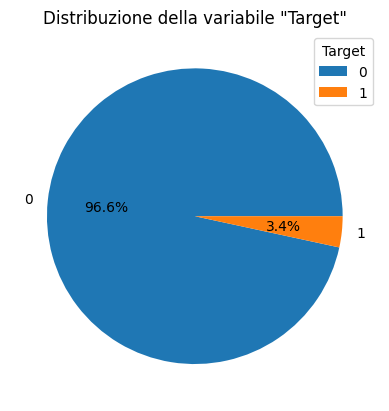

In [12]:
target = df["Target"].value_counts()

plt.pie(target, labels=["0", "1"], autopct='%1.1f%%')
plt.legend(title="Target")
plt.title("Distribuzione della variabile \"Target\"")
plt.show()

Vediamo come il dataset risulti essere sbilanciato in favore della classe 0, ovvero la classe che indica che la macchina non si è guastata. Sarà quindi necessario effettuare un ribilanciamento di esso.

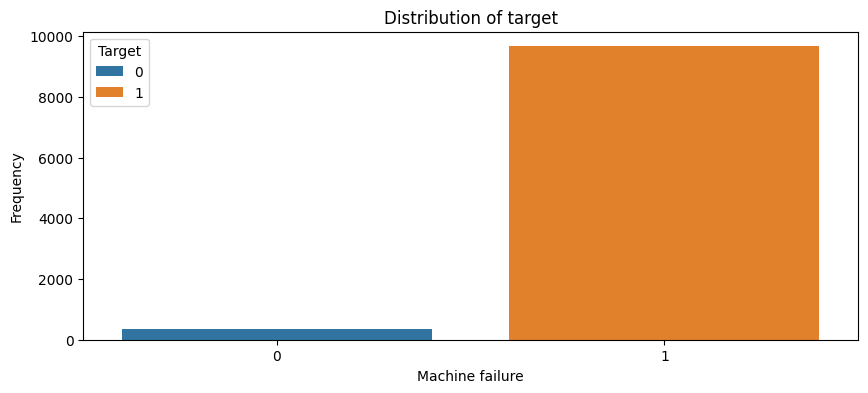

In [13]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Target', data=df, hue='Target')
plt.title("Distribution of target")
plt.xlabel("Machine failure")
plt.ylabel("Frequency")
plt.show()

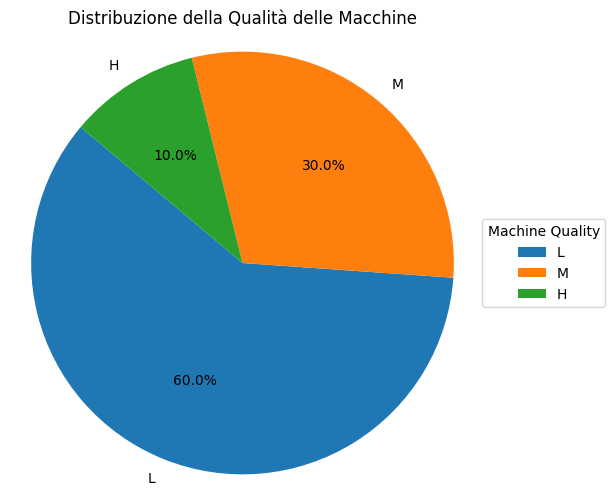

In [14]:
# Extracting the unique machine qualities and their counts
machine_qualities = df['Type'].value_counts()
labels = machine_qualities.index
counts = machine_qualities.values

# Creating the pie chart with more descriptive labels and a legend
plt.figure(figsize=(6, 6))  # Adjusting figure size for better readability
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione della Qualità delle Macchine')
plt.legend(labels, title="Machine Quality", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

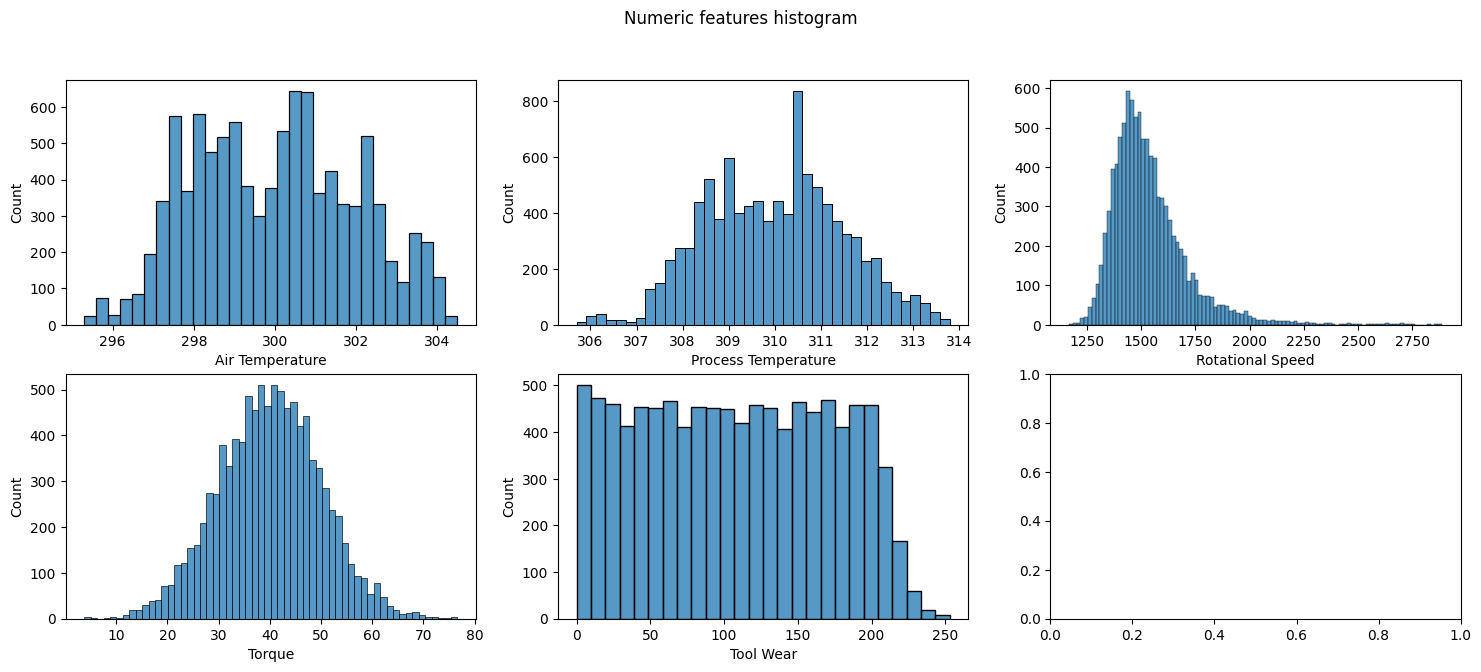

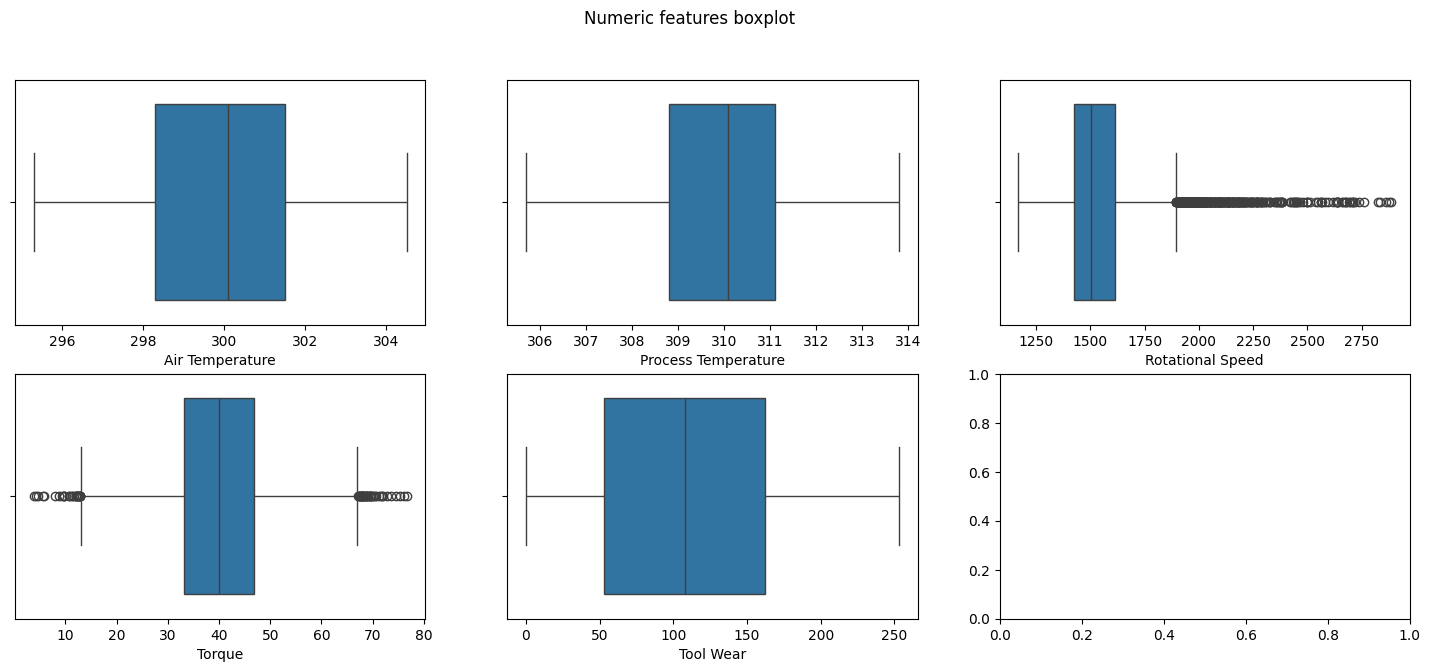

In [15]:
num_features = [feature for feature in df.drop(['Target', 'Type'], axis=1)]
# Histograms of numeric features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

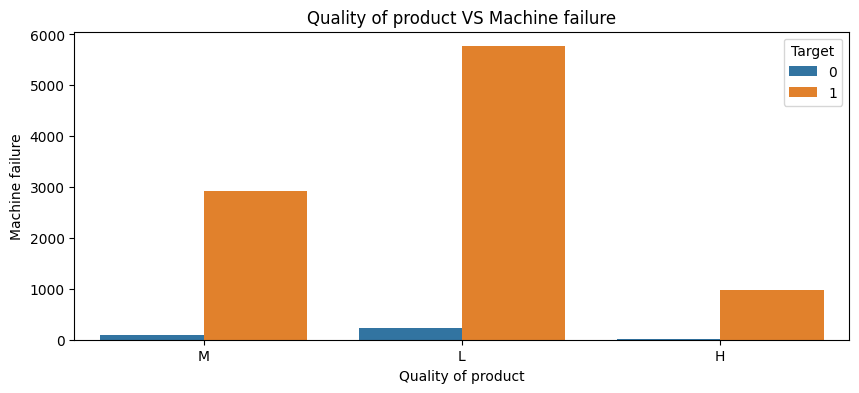

In [16]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Type', hue='Target')
plt.title('Quality of product VS Machine failure')
plt.xlabel('Quality of product')
plt.ylabel('Machine failure')
plt.show()

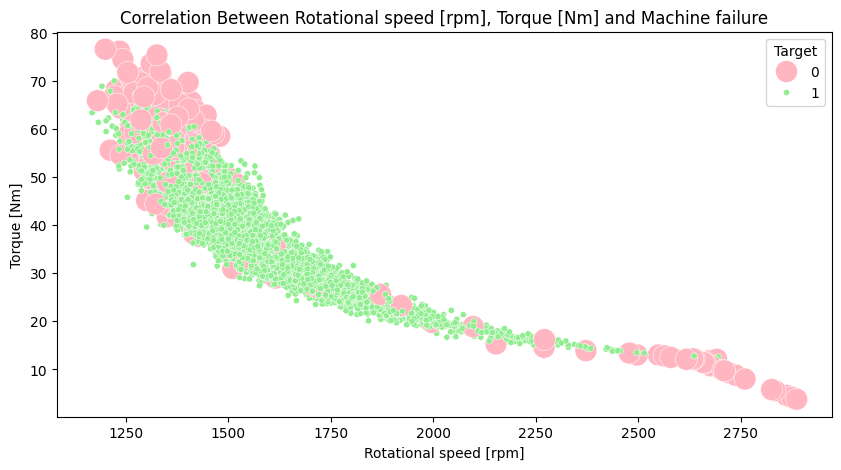

In [17]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Rotational Speed', y='Torque', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(20, 250))
plt.title('Correlation Between Rotational speed [rpm], Torque [Nm] and Machine failure')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()

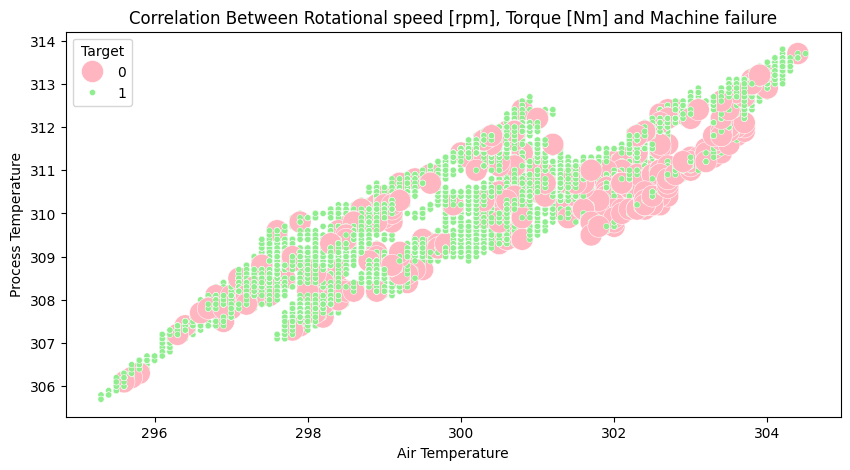

In [18]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Air Temperature', y='Process Temperature', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(20, 250))
plt.title('Correlation Between Rotational speed [rpm], Torque [Nm] and Machine failure')
plt.xlabel('Air Temperature')
plt.ylabel('Process Temperature')
plt.show()

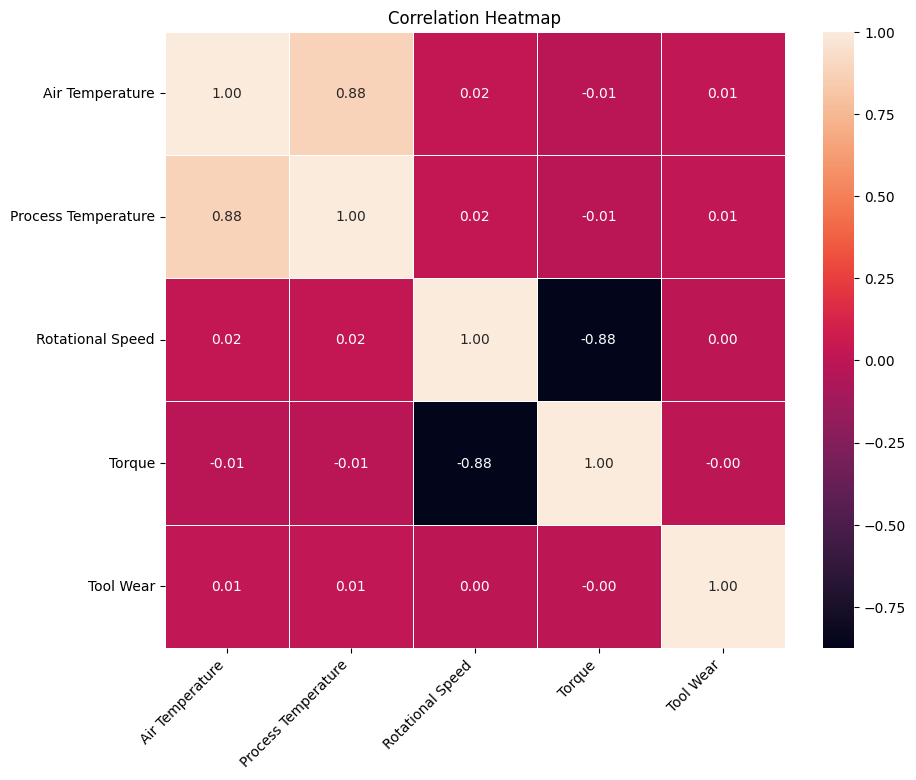

In [19]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

Vediamo dalla matrice di correlazione come le feature siano debolmente correlate tra loro, eccezione fatta per "Air Temperature" e "Process Temperature" che risultano avere una correlazione di 0.88, così come "Rotational Speed" e "Torque". Possiamo però considerare di introdurre 2 nuove feature rappresentanti una combinazione lineare delle due coppie di feature, ovvero:
- "Temperature Difference" = "Process Temperature" - "Air Temperature"
- "Power" = "a" * "Rotational Speed" * "Torque", con a = 0.104719755

In [20]:
df['Temperature Difference']= df['Process Temperature'] - df['Air Temperature']
df['Power'] = df['Torque'] * df['Rotational Speed'] * 0.104719755

In [21]:
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Temperature Difference,Power
0,M,298.1,308.6,1551,42.8,0,1,10.5,6951.590552
1,L,298.2,308.7,1408,46.3,3,1,10.5,6826.722716
2,L,298.1,308.5,1498,49.4,5,1,10.4,7749.387534
3,L,298.2,308.6,1433,39.5,7,1,10.4,5927.504652
4,L,298.2,308.7,1408,40.0,9,1,10.5,5897.816602


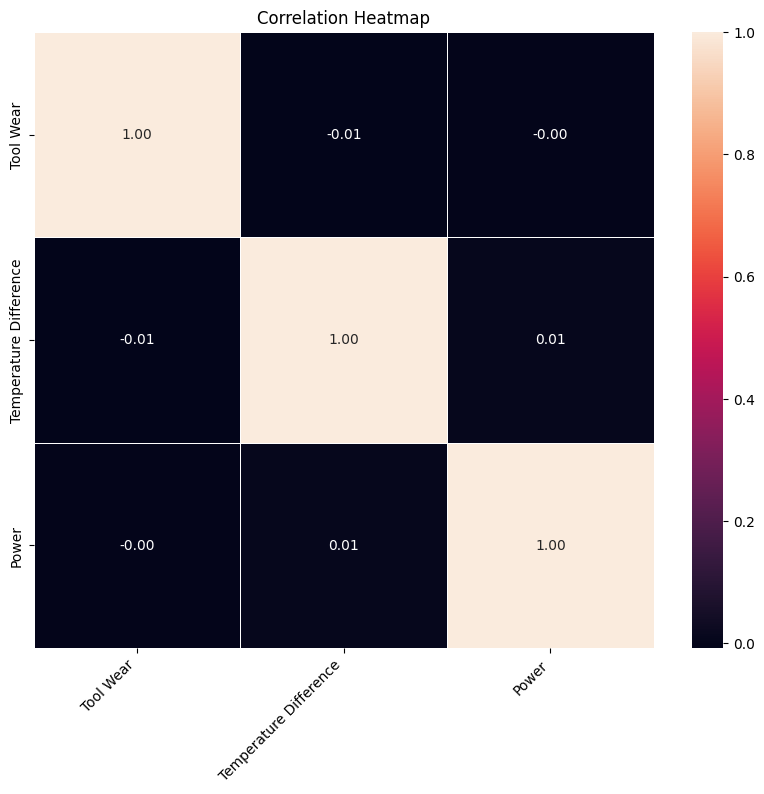

In [22]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Tool Wear', 'Temperature Difference', 'Power']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

## Preparazione dei dati

Come prima cosa andiamo ad usare un Encoder alla feature 'Type' per trasformarla in variabile numerica:

In [23]:
df['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

In [24]:

ordinal_feat=[['M'],
              ['L'],
              ['H']
              ]
order = ['L', 'M', 'H']

# Inizializza l'OrdinalEncoder
encoder = OrdinalEncoder(categories= [order])

# Adatta e trasforma i dati con l'OrdinalEncoder
encoded_data = encoder.fit_transform(ordinal_feat)

# Stampa i dati codificati
print(encoded_data)

[[1.]
 [0.]
 [2.]]


Andiamo ad effettuare la mappatura delle etichette per allinearle con i valori nel dataset:

In [25]:
mappatura_etichette = {
    ordinal_feat[0][0]: encoded_data[0][0],
    ordinal_feat[1][0]: encoded_data[1][0],
    ordinal_feat[2][0]: encoded_data[2][0]
}
df = df.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
df['Type'] = df['Type'].astype(int)
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target,Temperature Difference,Power
0,1,298.1,308.6,1551,42.8,0,1,10.5,6951.590552
1,0,298.2,308.7,1408,46.3,3,1,10.5,6826.722716
2,0,298.1,308.5,1498,49.4,5,1,10.4,7749.387534
3,0,298.2,308.6,1433,39.5,7,1,10.4,5927.504652
4,0,298.2,308.7,1408,40.0,9,1,10.5,5897.816602


Dividiamo il dataset in train e test:

In [26]:
y = df['Target']
X = df.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Andiamo ora ad effettuare il resampling del nostro training set. Per farlo useremo il modello SMOTEENN, modello che combina le tecniche di oversampling e di undersampling utilizzando SMOTE e Edited Nearest Neighbour (ENN)"

In [27]:
print("Prima del resampling:")
print(y_train.value_counts())

print("\n")

smenn = SMOTEENN(random_state=2)
X_train, y_train = smenn.fit_resample(X_train, y_train)

print("Dopo il resampling:")
print(y_train.value_counts())

Prima del resampling:
Target
1    7722
0     278
Name: count, dtype: int64


Dopo il resampling:
Target
0    7086
1    6641
Name: count, dtype: int64


Scaliamo i dati:

In [28]:
features_to_scale = ['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear', 'Temperature Difference', 'Power']

scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

Calcoliamo i PCA:


In [29]:
# Crea un'istanza di PCA
pca = PCA()  # n_components specifica il numero di componenti principali da mantenere

# Adatta il modello PCA ai dati di addestramento e applica la riduzione della dimensionalità
X_train_pca = pca.fit_transform(X_train)

# Applica la trasformazione PCA ai dati di test
X_test_pca = pca.transform(X_test)

# X_train_pca e X_test_pca ora contengono i dati trasformati
X_train_pca

array([[-9.35145840e-01,  2.01923175e+00,  1.93409463e+00, ...,
         7.15262517e-01, -2.28406855e-01, -3.36127987e-15],
       [-1.66806207e+00, -6.33787083e-01,  1.99975837e-01, ...,
         5.31526507e-01,  1.84360748e-01,  8.95452757e-14],
       [ 1.96228926e+00,  4.71547542e-01, -1.98197389e+00, ...,
        -4.86247307e-01, -4.32774441e-02, -5.44481356e-14],
       ...,
       [-1.04094805e+00, -1.35925485e+00, -1.53829990e+00, ...,
         6.63696342e-01, -1.01631585e-01,  1.15164327e-16],
       [ 2.51881384e+00,  2.56561337e+00,  1.66108219e+00, ...,
        -1.48665681e-01,  9.69927299e-02, -5.80268392e-18],
       [ 2.06761010e+00, -6.65167904e-01,  8.53625894e-01, ...,
        -3.89755916e-01, -9.73675205e-02,  8.85774842e-18]])

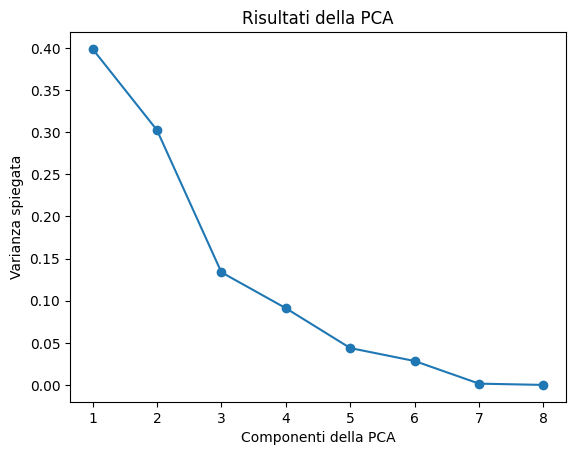

In [30]:
# Crea un grafico della varianza spiegata per ogni componente
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

## Addestramento dei Modelli

In [31]:
def prediction_evaluation(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", bal_acc)
    print("MCC: ", mcc)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)
    print("ROC AUC: ", roc_auc)
     # Estrazione dei valori dalla matrice di confusione
    TP, FP, FN, TN = conf_matrix.ravel()

    # Calcolo della specificità
    specificity = TN / (TN + FP)
    print("Specificità:", specificity)

    # calcolo la precision negativa
    print("Precision negativa: ", TN/(TN+FN))

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.title('Confusion Matrix')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)


    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

### Binary DecisionTreeClassifier


I Decision Tree sono modelli di apprendimento automatico utilizzati sia per problemi di classificazione che di regressione. Operano dividendo ripetutamente il dataset in sottoinsiemi omogenei in base alle caratteristiche dei dati, fino a quando non viene raggiunta una condizione di stop predefinita. Due caratteristiche principali degli alberi decisionali sono la versatilità e la semplicità.
Andiamo quindi ad addestrare un modello di Decision Tree:

Accuracy:  0.934
Balanced Accuracy:  0.8548178459405305
MCC:  0.44353639913342424
Precision:  0.9923705722070845
Recall:  0.9391438886023724
F1:  0.9650238473767887
ROC AUC:  0.8548178459405305
Specificità: 0.9923705722070845
Precision negativa:  0.9391438886023724


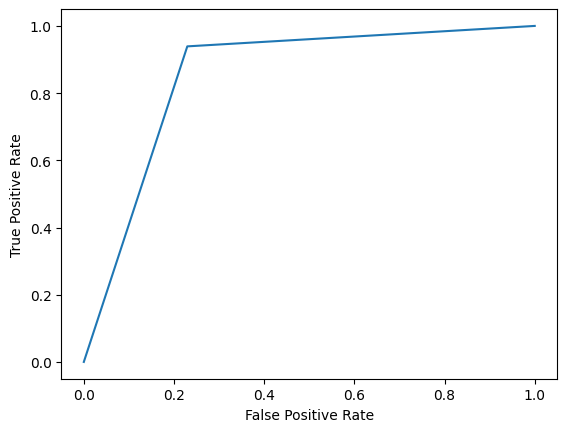

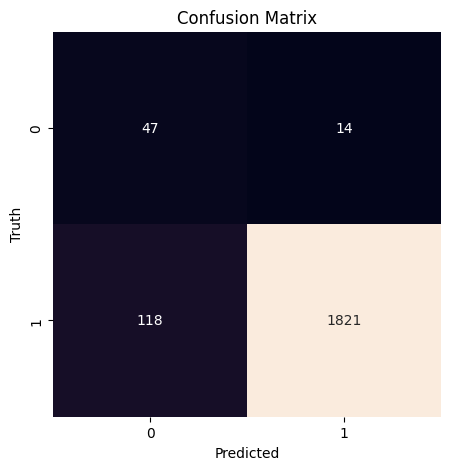

In [32]:
# Crea un'istanza del classificatore
clf = DecisionTreeClassifier(criterion="gini")

# Addestra il modello
clf.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred = clf.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred)

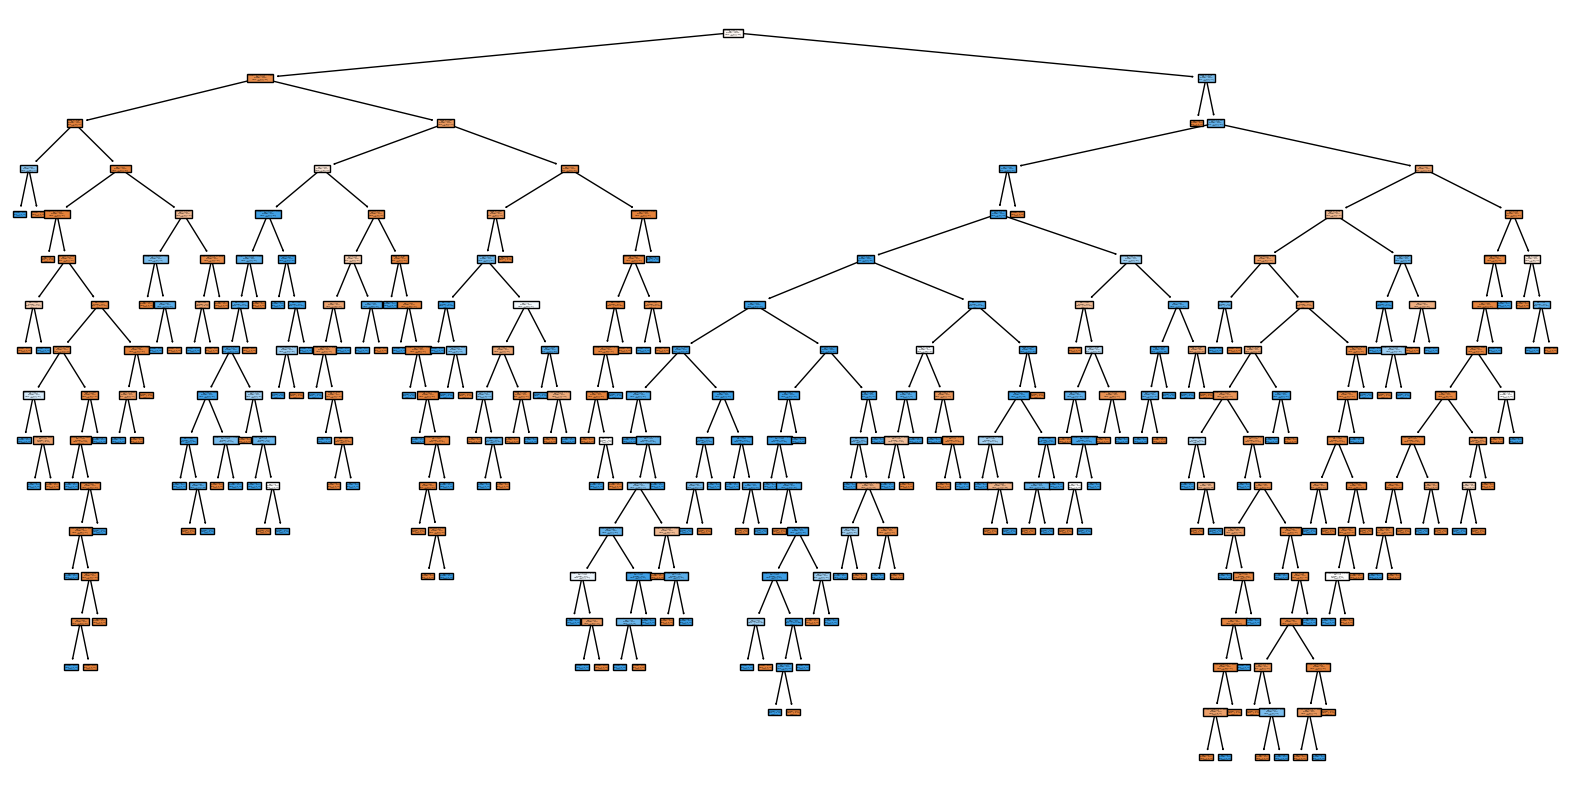

In [33]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning


Il pruning dell'albero è una tecnica di Machine Learning utilizzata per ottimizzare i modelli di albero di decisione riducendo l'overfitting e migliorando la generalizzazione a nuovi dati. Per il nostro caso utilizzeremo la tecninca di post-pruning.
Il post-pruning comporta la rimozione di rami o nodi per migliorare la capacità del modello di generalizzare. In particolare verrà applicato il metodo CPP (Cost-Complexity Pruning), metodo che assegna un valore a ciascun sottoalbero principalmente in base alla sua accuratezza e complessità, quindi seleziona il sottoalbero con il costo più basso.

In [34]:
path=clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [35]:
# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.9405


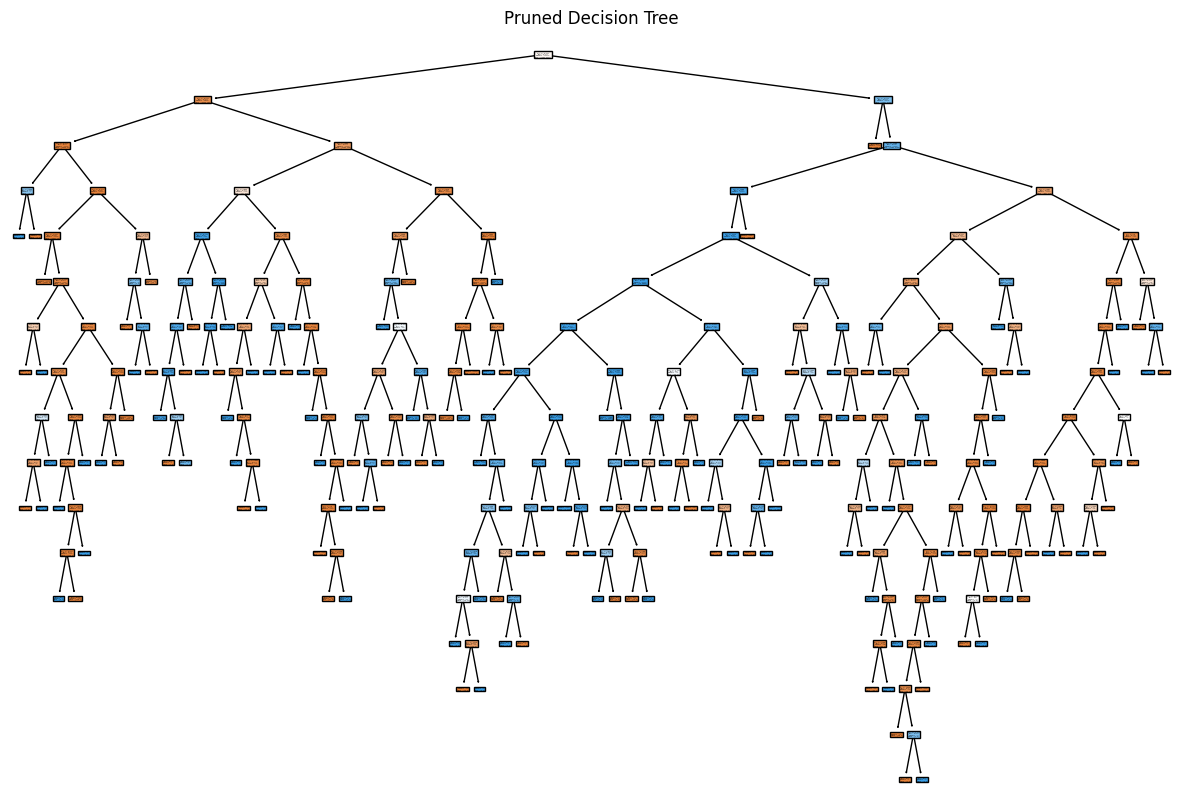

In [36]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

### Binary SVM

Le SVM (Support Vector Machines) sono un algoritmo di apprendimento supervisionato utilizzato sia per problemi di classificazione che di regressione. Le SVM sono potenti strumenti di classificazione che si distinguono per la loro capacità di trovare iperpiani di decisione ottimali che massimizzano il margine tra le classi e per la loro flessibilità nell'affrontare problemi complessi tramite il kernel trick.

Alleniamo ora il modello:

Accuracy:  0.912
Balanced Accuracy:  0.8672883605711919
MCC:  0.40780509105569207
Precision:  0.9938375350140056
Recall:  0.9149045899948427
F1:  0.9527389903329753
ROC AUC:  0.8672883605711919
Specificità: 0.9938375350140056
Precision negativa:  0.9149045899948427


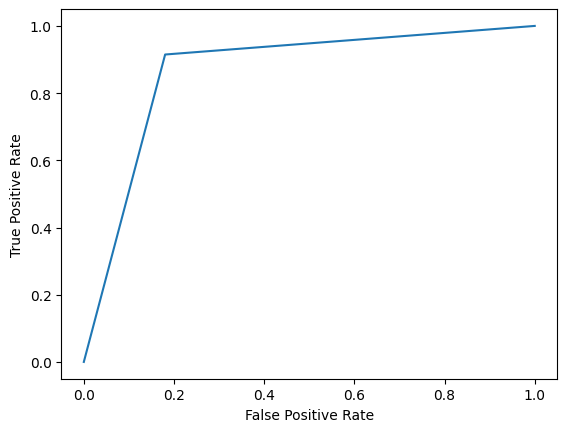

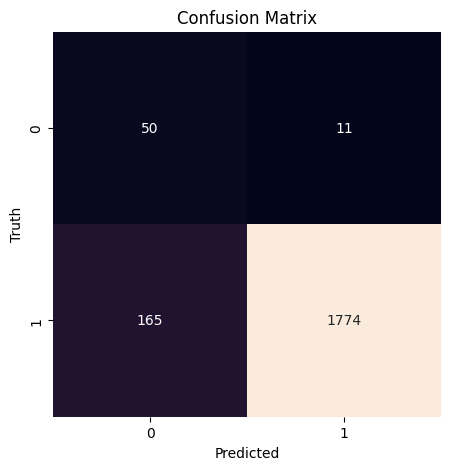

In [37]:
# Crea un'istanza del classificatore
svm = SVC()

# Addestra il modello
svm.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred_svm = svm.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred_svm)

#### Fine Tuning


Il fine tuning di un modello SVM può essere fatto regolando i suoi parametri per trovare la loro combinazione migliore; in particolare analizzeremo i seguenti parametri:
- C: Questo parametro controlla il compromesso tra ottenere il margine più ampio possibile e minimizzare il tasso di classificazione errata.
- gamma: Questo parametro controlla quanto influisce un singolo esempio di addestramento.
- kernel: Questo parametro controlla il tipo di iperpiano utilizzato per separare i dati.

In [38]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   6.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.8s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.6s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy:  0.9425
Balanced Accuracy:  0.8115684102841586
MCC:  0.4256423457079071
Precision:  0.9892703862660944
Recall:  0.9510056730273336
F1:  0.9697607152248225
ROC AUC:  0.8115684102841587
Specificità: 0.9892703862660944
Precision negativa:  0.9510056730273336


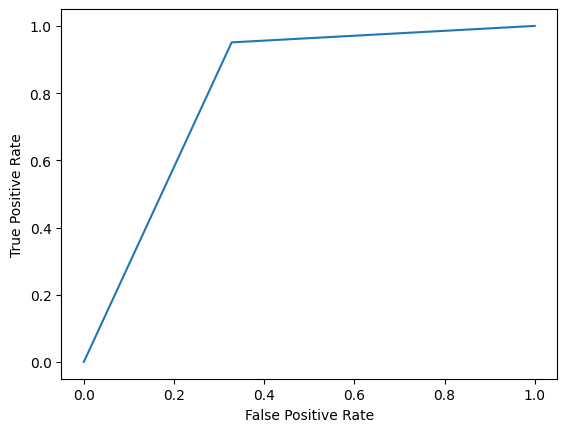

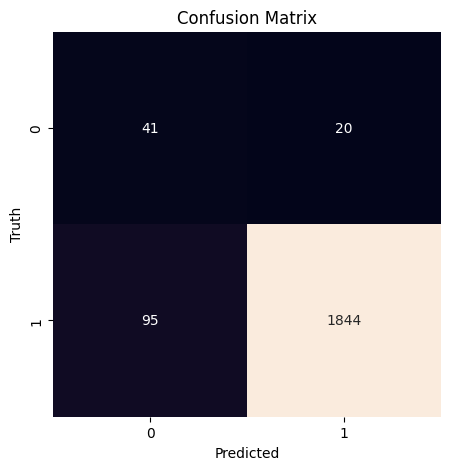

In [40]:
# Crea un'istanza del classificatore
svm = SVC(**grid.best_params_)

# Addestra il modello
svm.fit(X_train, y_train)

# Fai delle previsioni sul set di test
y_pred_svm = svm.predict(X_test)

# Valuta le previsioni
prediction_evaluation(y_test, y_pred_svm)